## Introduction

The project requirements asks us to conduct analysis on two or more data sets after their merging. One powerful method for understanding the bivariate relationships of important variables is a SPLOM visualization which is further explained later on. This gives a quick glance on the overall distribution of the data and any signs of linear trends.

This notebook (2/3) explores the bivariate relationships between the refrigerated truck volumes, COVID-19 cases, and the fruit price.

In [1]:
# import data science packages
import numpy as np
import pandas as pd

# import visualization packages
import matplotlib.pyplot as plt
%matplotlib inline

# import custom packages
import datasets
import utils

## Import Data
First, we need to import the other data sets on the refrigerated truck volume and COVID-19 cases.

In [2]:
# import the COVID-19 data set
covid_df = pd.read_csv('data\Weekly_United_States_COVID-19_Cases_and_Deaths_by_State.csv')
covid_df

,date_updated,state,start_date,end_date,tot_cases,new_cases,tot_deaths,new_deaths,new_historic_cases,new_historic_deaths
0,2020-01-23,AK,2020-01-16,2020-01-22,0,0,0,0,0,0
1,2020-01-30,AK,2020-01-23,2020-01-29,0,0,0,0,0,0
2,2020-02-06,AK,2020-01-30,2020-02-05,0,0,0,0,0,0
3,2020-02-13,AK,2020-02-06,2020-02-12,0,0,0,0,0,0
4,2020-02-20,AK,2020-02-13,2020-02-19,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
9355,2022-12-15,WY,2022-12-08,2022-12-14,182198,503,1950,12,0,0
9356,2022-12-22,WY,2022-12-15,2022-12-21,182581,383,1958,8,0,0
9357,2022-12-29,WY,2022-12-22,2022-12-28,182847,266,1958,0,0,0
9358,2023-01-05,WY,2022-12-29,2023-01-04,183151,304,1958,0,0,0


In [3]:
# convert to datetime type
for col in ['start_date', 'end_date']:
    covid_df.loc[:,col] = pd.to_datetime(covid_df[col], format='%Y-%m-%d')

We have modularized some methods for importing and cleaning our data sets to reduce redundant code.

In [4]:
# import the refrigerated truck volume data set
truck_df = datasets.load_truck_data(start=2015, end=2022, trace=True)

# For our analysis, we filter the data frame to only include data for California and Florida.
REGIONS = ['California', 'Florida']
filtered_truck_df = truck_df[truck_df['Region'].isin(REGIONS).values]

# aggregate every week
weekly_truck_df = datasets.aggregate_truck_df(filtered_truck_df, rule='1W', trace=True)

The file 'data\Refrigerated_Truck_Volumes_2015.csv' contains 114836 rows and 14 columns.
The file 'data\Refrigerated_Truck_Volumes_2016.csv' contains 115813 rows and 14 columns.
The file 'data\Refrigerated_Truck_Volumes_2017.csv' contains 115112 rows and 14 columns.
The file 'data\Refrigerated_Truck_Volumes_2018.csv' contains 116071 rows and 14 columns.
The file 'data\Refrigerated_Truck_Volumes_2019.csv' contains 121176 rows and 14 columns.
The file 'data\Refrigerated_Truck_Volumes_2020.csv' contains 129428 rows and 14 columns.
The file 'data\Refrigerated_Truck_Volumes_2021.csv' contains 140029 rows and 14 columns.
The file 'data\Refrigerated_Truck_Volumes_2022.csv' contains 137708 rows and 14 columns.
The full data frame contains 990173 rows and 14 columns.
The cleaned data frame contains 856759 rows and 9 columns.


In [5]:
# fix the naming of some values
weekly_truck_df.rename(index=str, columns={'date': 'start_date'}, inplace=True)
weekly_truck_df.replace('California', 'CA',inplace=True)
weekly_truck_df.replace('Florida', 'FL',inplace=True)

Let's now obtain the fruit price data set.

In [6]:
# import the fruit price data set (in pivot format)
fruit_df_pivot = datasets.load_fruit_data(trace=True)

In [7]:
# convert to long format
fruit_df = fruit_df_pivot.melt(id_vars=['Commodity'], var_name='date', value_name='price')

# convert to datetime type
fruit_df.loc[:,'date'] = pd.to_datetime(fruit_df['date'], format='%Y-%m-%d')

# clean up the column names
fruit_df.rename(index=str, columns={'date': 'start_date'}, inplace=True)
fruit_df.replace('Avocados 4/', 'Avocados',inplace=True)
fruit_df.replace('Cantaloupes', 'Cantaloupe',inplace=True)
fruit_df.replace('Honeydew', 'Honeydews',inplace=True)
fruit_df.replace('Melons, mixed', 'Mixed and Misc Melons',inplace=True)
fruit_df.replace('Watermelon', 'Watermelons',inplace=True)
fruit_df.replace('Watermelon, seeded', 'Watermelons, Seeded',inplace=True)
fruit_df.replace('Watermelon, seedless', 'Watermelons, Seedless',inplace=True)


In [8]:
fruit_df

,Commodity,start_date,price
0,Apples,2022-04-23,1.437777
1,Avocados,2022-04-23,1.580000
2,Bananas,2022-04-23,0.520000
3,Blueberries,2022-04-23,3.020000
4,Cantaloupe,2022-04-23,0.810000
...,...,...,...
2283,Raspberries,2020-05-02,2.270000
2284,Strawberries,2020-05-02,2.540000
2285,Watermelons,2020-05-02,NaN
2286,"Watermelons, Seeded",2020-05-02,0.270000


In [9]:
df1 = covid_df.merge(weekly_truck_df, how='cross')
df1 = df1.query("start_date_y >= start_date_x & start_date_y <= end_date & Region == state")
df2 = covid_df.merge(fruit_df, how='cross')
df2 = df2.query("start_date_y >= start_date_x & start_date_y <= end_date")

In [10]:
truck = df1.loc[:,['start_date_x','new_cases','Commodity','10,000 LBS']]
price = df2.loc[:,['start_date_x','Commodity','price']]
df = pd.merge(truck,price)

## SPLOM Visualization

A SPLOM is a visualization technique that showcases bivariate relationships in a matrix format. In particular, we are exploring linear relationships between the refrigerated truck volumes, COVID-19 cases, and the fruit price. With these linear relationships, we also create best line of fits to check for any strong correlations. We decide to use [matplotlib](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) for this visualization.

C:\Users\mrquo\AppData\Local\Temp\ipykernel_11916\905072245.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


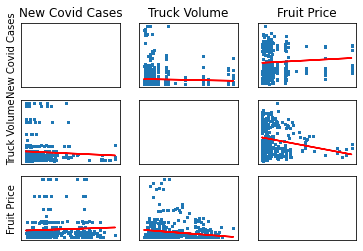

In [11]:
fig, axs = plt.subplots(3, 3)

variables = ['new_cases','10,000 LBS','price']

for i in range(3):
    for j in range(3):
        if j != i:
            sub = df.loc[:,[variables[i],variables[j]]]
            sub.dropna(inplace=True)
            x = sub.loc[:,variables[i]]
            y = sub.loc[:,variables[j]]
            axs[i,j].scatter(x, y, s=1)
            m, b = np.polyfit(x, y, 1)
            axs[i,j].plot(x, m*x+b, color='red')
            
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

names = ['New Covid Cases','Truck Volume','Fruit Price']

cols = names
rows = names

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row)

fig.show()

We can see that the most obvious correlation is the negative relationship between fruit price and truck volume. Next is the slightly positive correlation between new COVID-19 cases and fruit prices. We barely see any correlation between COVID-19 cases increases and truck volume changes. Since we didn't find much correlation between COVID-19 cases and the other two variables, we decided to look deeper into each variable for their trend.

## Record Dependencies

We list our dependencies at the end of this notebook.

In [12]:
import sys
!{sys.executable} -m pip install watermark

In [13]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,matplotlib

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.4.0

numpy     : 1.21.5
pandas    : 1.4.3
matplotlib: 3.5.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 33 Stepping 0, AuthenticAMD
CPU cores   : 12
Architecture: 64bit

